In [ ]:
!git clone https://github.com/jayeshsaita/Day-Night-Classifier

Cloning into 'Day-Night-Classifier'...
remote: Enumerating objects: 1303, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 1303 (delta 8), reused 27 (delta 5), pack-reused 1271
Receiving objects: 100% (1303/1303), 91.01 MiB | 43.42 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
import os
os.chdir('Day-Night-Classifier/')

In [ ]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

In [ ]:
# example of preparing the horses and zebra dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path = '/content/Day-Night-Classifier/day_night_dataset/'
# load dataset A
dataA1 = load_images(path + 'train/day/')
dataAB = load_images(path + 'val/day/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'train/night/')
dataB2 = load_images(path + 'val/night/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'day2night_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (681, 256, 256, 3)
Loaded dataB:  (602, 256, 256, 3)
Saved dataset:  day2night_256.npz


In [ ]:
!rm -r /content/Day-Night-Classifier

Loaded:  (681, 256, 256, 3) (602, 256, 256, 3)


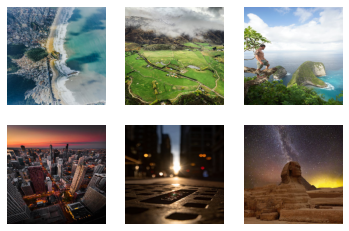

In [ ]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('day2night_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [ ]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-bnw90hjr
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-bnw90hjr
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=3a8fa968de5a58105b6c34cc10720ce13f4a1c29c8a1541d167bbfe346f68403
  Stored in directory: /tmp/pip-ephem-wheel-cache-ep9c5voj/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 50, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
dataset = load_real_samples('day2night_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (681, 256, 256, 3) (602, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>2294, dA[0.025,0.129] dB[0.097,0.372] g[4.438,5.354]
>2295, dA[0.215,0.382] dB[0.028,0.026] g[5.881,6.855]
>2296, dA[0.056,0.175] dB[0.045,0.015] g[9.399,8.066]
>2297, dA[0.111,0.054] dB[0.356,0.034] g[7.753,10.243]
>2298, dA[0.182,0.080] dB[0.019,0.075] g[5.444,5.253]
>2299, dA[0.018,0.080] dB[0.150,0.187] g[6.267,6.871]
>2300, dA[0.077,0.029] dB[0.044,0.131] g[6.985,9.239]
>2301, dA[0.086,0.027] dB[0.027,0.093] g[6.829,8.861]
>2302, dA[0.130,0.014] dB[0.662,0.058] g[6.825,7.247]
>2303, dA[0.093,0.245] dB[0.059,0.096] g[4.758,5.204]
>2304, dA[0.018,0.021] dB[0.025,0.052] g[4.759,4.769]
>2305, dA[0.011,0.022] dB[0.101,0.031] g[6.972,7.076]
>2306, dA[0.071,0.013] dB[0.115,0.045] g[5.157,5.588]
>2307, dA[0.020,0.050] dB[0.013,0.040] g[5.460,5.695]
>2308, dA[0.202,0.116] dB[0.029,0.038] g[5.620,6.562]
>2309, dA[0.025,0.076] dB[0.023,0.013] g[9.988,9.057]
>2310, dA[0.211,0.072] dB[0.007,0.006] g[10.718,9.443]
>2311, dA[0.016,0.103] dB[0.0

KeyboardInterrupt: ignored

## Validation samples

In [ ]:
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-9nidgkd9
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-9nidgkd9
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=b24ce494590e9edb23812e851b7de1654c804c19005a36550be82c2ffee8bdb3
  Stored in directory: /tmp/pip-ephem-wheel-cache-w0r0k8ou/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot

In [ ]:
# load the model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/MyDrive/samsung/Day 2 night keras models/g_model_AtoB_006810.h5', cust)

In [ ]:
def predict_image(img_src):
  image_src = load_image(img_src)
  # translate image
  image_tar = model_AtoB.predict(image_src)
  # scale from [-1,1] to [0,1]
  image_tar = (image_tar + 1) / 2.0
  # plot the translated image
  pyplot.imshow(image_tar[0])
  pyplot.show()

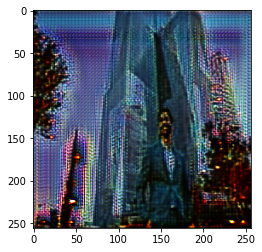

In [ ]:
predict_image('/content/sample Images/download.jpg')

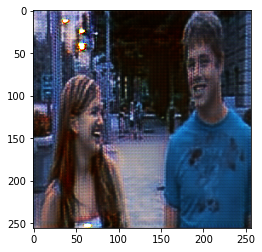

In [ ]:
predict_image('/content/sample Images/images (3).jpg')

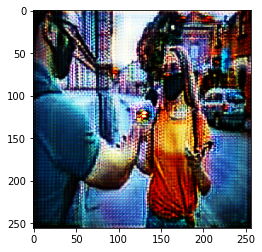

In [ ]:
predict_image('/content/sample Images/images.jpg')

## Test on New Unknown Images

In [ ]:
from os import listdir
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
def load_image(filename, size=(256,256)):
	# load and resize the image
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# transform in a sample
	# pixels = expand_dims(pixels, 0)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	return pixels

def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		print(filename)
		pixels = load_image(path + filename, size=size)
		# convert to numpy array
		# pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)


In [ ]:
data = load_images('/content/sample Images/')

images (3).jpg
images.jpg
download.jpg


In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	X = (X+1)/2.0
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

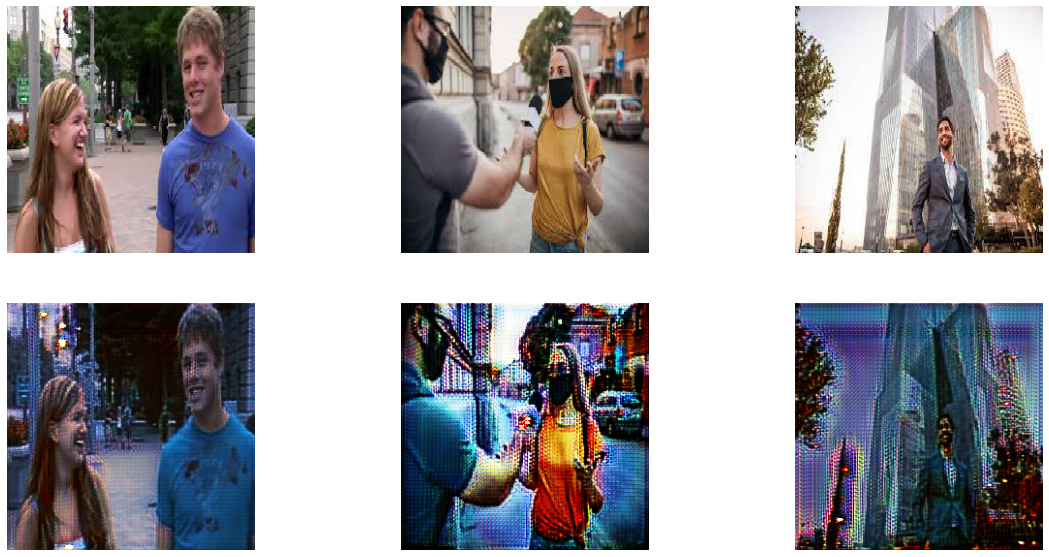

In [ ]:
X_out, _ = generate_fake_samples(model_AtoB, data, 0)
n_samples = data.shape[0]
f = pyplot.figure(figsize=(20,10))
path='/content/sample Images/'
i=0
for filename in listdir(path):	
	pixels = load_img(path+filename, target_size=(256,256))
	# convert to numpy array
	# pixels = img_to_array(pixels)
	pyplot.subplot(2, n_samples, 1 + i)
	i=i+1
	pyplot.axis('off')
	pyplot.imshow(pixels)

for i in range(n_samples):
  pyplot.subplot(2, n_samples, 1 + n_samples + i)
  pyplot.axis('off')
  pyplot.imshow(X_out[i])
# save plot to file
filename1 = '%s_generated_plot.png' % ('Sample Images')
# pyplot.savefig(filename1)
# pyplot.close()
pyplot.show()